This notebook will be used to show some functions in ellipse.py and maximize the accessibility of this module.

#Using the ellipse.py Module
The velocities have to be prepared and set up in a certain way before they can be put through the tidal analysis. They need to be orthogonal, rotated to align with N/S, unstaggered and masked. The functions in ellipse.py handle these calculations.

This notebook outlines how to calculate tidal ellipses for :

* Nowcast files
* Other simulation files

In [1]:
import datetime
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as nc
from matplotlib.patches import Ellipse

from salishsea_tools import (viz_tools, tidetools as tt, ellipse, nc_tools)
from salishsea_tools.nowcast import (analyze, research_VENUS)


%matplotlib inline

##Case 1: Nowcast files

The functions were originally developed to analyze tidal currents from nowcast results. Given a date range and grid coordinate, a single function can be used to analyze the time series and generate ellipse parameters.

###get_params_nowcast()
By default, this function will calculate tidal ellipses at each model depth. An example is shown below.

First, define the date range and grid coordinates of interest.


In [2]:
path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'

#The longer the date range the longer the analysis takes but the more tidal constituents it can resolve
to=datetime.datetime(2015,7,10)
tf=datetime.datetime(2015,7,17)

i = [280] # x-index
j = [400] # y-index
nconst = 2 # number of constituents to be analyzed

Note: The i, j coordinates must be represented as a list or array. If multiple grid points are to be analyzed, they must cover an area. This means that the values in i (and j) must be separated by one. Further, since analyzing currents requires unstaggering, both i and j must be greater than 0.

We also have to define the number of constituents to be analyzed. The possibilities are:
* 2 - M2, K1
* 4 - M2, K1, S2, O1
* 6 - M2, K1, S2, O1, N2, P1
* 8 - M2, K1, S2, O1, N2, P1, K2, Q1

Note that a long time series is required to analyze many constituents.

Next, a simlple call to get_params_nowcast() returns the ellipse parameters in a dictionary object (params) and the depths associated with the ellipse parameters (dep).

In [3]:
params, dep = ellipse.get_params_nowcast(to, tf, i, j, path, nconst)

A quick demonstration of plotting the semi-major axis over depth is shown below.

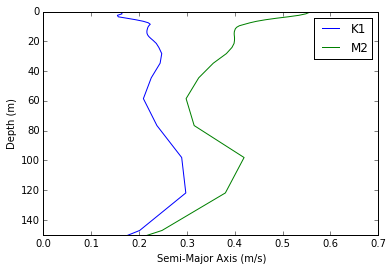

In [4]:
for key in params.iterkeys():
    plt.plot(np.squeeze(params[key]['Semi-Major Axis']), dep[:],label=key)
plt.axis([0,0.7,150,0])
plt.legend(loc=0)
plt.xlabel('Semi-Major Axis (m/s)')
plt.ylabel('Depth (m)')

If more constituents were analyzed then params would have additional keys representing those constituents.

Each constituent in params also contains keys for the Semi-Minor Axis, Phase, and Inclination.

###Ellipses over an area

We can also analyze the tidal currents over an area and at a single depth.


In [5]:
i = np.arange(280,300) # x-indices
j = np.arange(400,440) # y-indices
nconst = 2 # number of constituents to be analyzed
depth = 1 # depth of analysis in meters

params, dep = ellipse.get_params_nowcast(to, tf, i, j, path, nconst,depthrange=depth)
print dep

0.5


Note: the ellipse is analyzed at the closest model level that is less than depth. 

It is straightforward to plot the phase.

1.1363636363636362

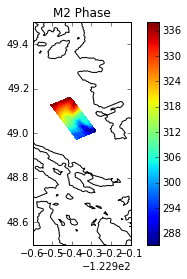

In [6]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = grid.variables['Bathymetry']
lons = grid.variables['nav_lon']
lats = grid.variables['nav_lat']

fig,ax=plt.subplots(1,1)
mesh=ax.pcolormesh(lons[j,i],lats[j,i],params['M2']['Phase'])
plt.colorbar(mesh,ax=ax)
viz_tools.plot_coastline(ax,grid,coords='map')
ax.set_xlim([-123.5,-123])
ax.set_ylim([48.5,49.5])
ax.set_title('M2 Phase')
viz_tools.set_aspect(ax)

###Depth averaged ellipses
Finally, we can also calculate the ellipses for the depth averaged currents over a depth range. The depav argument should be set to True.

In [7]:
i = [280] # x-index
j = [400] # y-index
depthrange = [0,100] # depth range in meters.
nconst = 4 # number of constituents to be analyzed

params, dep = ellipse.get_params_nowcast(to, tf, i, j, path, nconst,depthrange=depthrange, depav=True)
print 'S2 ellipse parameters'
print params['S2']
print 'Range of depth averaging:'
print dep

S2 ellipse parameters
{'Phase': array([[ 354.9102976]]), 'Semi-Major Axis': array([[ 0.04274396]]), 'Semi-Minor Axis': array([[-0.00943675]]), 'Inclination': array([[ 131.62047723]])}
Range of depth averaging:
[  0.5000003    1.5000031    2.50001144   3.50003052   4.50007057
   5.50015068   6.50031042   7.50062323   8.50123596   9.50243282
  10.50476551  11.50931168  12.51816654  13.53541183  14.56898212
  15.63428783  16.76117325  18.00713539  19.48178482  21.38997841
  24.10025597  28.22991562  34.68575668  44.51772308  58.48433304
  76.58558655  98.06295776]


And an example for plotting the S2 ellipse.

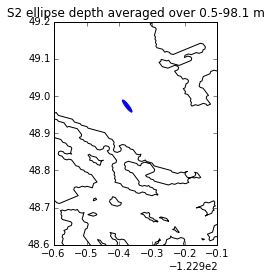

In [8]:
fig, ax = plt.subplots(1,1)
major = params['S2']['Semi-Major Axis'][0]
minor = params['S2']['Semi-Minor Axis'][0] 
inc = params['S2']['Inclination'][0]
#color is blue if counterclockise (minor<0) and red if clockwise
color = 'b' 
if minor >= 0:
    color = 'r'
ell = Ellipse(xy=(lons[j,i],lats[j,i]),width = major, 
              height =minor, angle= inc,
              color=color)
ax.add_artist(ell)
viz_tools.plot_coastline(ax,grid,coords='map')
ax.set_xlim([-123.5,-123])
ax.set_ylim([48.6,49.2])
viz_tools.set_aspect(ax)
ax.set_title('S2 ellipse depth averaged over {0:.3}-{1:.3} m'.format(dep[0],dep[-1]))

#Case 2: Other simulation files

We might want to analyze other simulations outside of the nowcast system. 

For example, we have a time series of U/V at the VENUS east node from a simulation saved at a 15 minute frequency. To analyze this time series we need to



1. Load the data
2. Unstagger and rotate the velocity fields to align with north/south. This is achieved with a function called prepare_velocities()
3. Create a dictionary object that containts the nodal corrections for our simulation (found in ocean.output)
4. Calculate the ellipse paramters with the ellipse_params() function.

These steps are shown in each of cells below.

Load data:

In [9]:
grid = '/ocean/mdunn/MEOPAR/jun_VENUS_east_gridded.nc'
G = nc.Dataset(grid)
u = G.variables['vozocrtx'][:]
v = G.variables['vomecrty'][:]
dep = G.variables['depthu'][:]

#Set up the time array that corresponds to the times of the u and v arrays in hours
t = G.variables['time_counter'][:]/3600.

Rorate and unstagger velocities:

In [10]:
u_rot,v_rot = ellipse.prepare_vel(u, v, depav=True, depth=dep)

Define nodal corrections:

In [11]:
NodalCorr = {
    'K1': {
        'ft': 0.763545,
        'uvt': 344.740346},
    'M2': {
        'ft': 1.035390,
        'uvt': 346.114490}}

nconst = 2

Calculate ellipse parameters:

In [12]:
params = ellipse.get_params(u_rot, v_rot, t, nconst, tidecorr = NodalCorr)
print params['K1']

{'Phase': array([[ 284.96515857]]), 'Semi-Major Axis': array([[ 0.34321001]]), 'Semi-Minor Axis': array([[-0.03599698]]), 'Inclination': array([[ 128.21677008]])}


The above result is a depth averaged analysis. Like earlier, we also have the flexibilty to analyze a range of depths or a single depth by slicing u and v at the desired model levels before passing to prepare_vel().

### Important considerations

If you would like to analyze your own tidal currents you need to consider the following:

1. Do you have a long enough time series to separate the desired constituents?
2. Do you have high frequency output (at least hourly)
3. The model U/V are at different physical locations so they must be unstaggered to a common location before performing the harmonics analysis. If you want to analyze the currents at T-point (400,300) then you should subset U and V as

$u_{sub} = U[..., 399:401,299:301]$ and $v_{sub} = V[..., 399:401,299:301]$.

The result is that $u_{sub}$ and $v_{sub}$ are both of shape (..., 2,2). If you subset this way, then $u_{sub}$ and $v_{sub}$ can be passed into prepare_vel() to perform the unstaggering and rotation.


### A note on phase

In these calculations, the phase is defined as the time that the current is aligned in the inclination direction with respect to GMT. The inclination is the direction of the maximum currents. Since this happens twice in an ellipse, the convention is to take the inclination to be between 0 and 180 degrees. As such, if the inclination in a region is close to 0 or 180, then the nearby ellipses may abruptly change inclination and it may appear as though the phase has a large discontinuity. The phase should be interpretted with caution.

## Plotting
While we have shown some plotting basics in this notebook, there are many other functions useful for plotting in the notebooks listed below:
* [CODAREllipse](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/CODAREllipse.ipynb) 
* [TidalEllipsesComparison](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/TidalEllipsesComparisons.ipynb)


#Future Improvements

At the moment, the harmonic analysis can only be performed for up to 8 constituents and in predetermined pairings, but, it may be necessary to expand this functionality. Some recommendations are

1. Modify tidetools.fittit() to take a "fit function" as an argument rather than a number of constituents. Along this line, it may be necessary to pass the apparam dictionary which stores the amplitude/phase of each constituent as an arugment, rather than construct it inside of the function. 
2. Nodal corrections are applied in ellipse.get_params(). What will be used for nodal corrections if we analyze constituents that are not forced in the model? How will we find the nodal factors for those constituents?
3. Come up with a way to adjust phase to be timing of max flood.